In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

### CSCI 447 Fall 2023 Kaggle Competition

In [2]:
train = pd.read_csv('data/kaggle_train.csv')
test = pd.read_csv('data/kaggle_test.csv')
# example = pd.read_csv('data/kaggle_example_submission.csv')

In [ ]:
train

In [ ]:
# show features that correlate most with target
train.corr()['target'].sort_values(ascending=False)

---

In [ ]:
# # Remove features that correlate weakly with target (run this to do that)
# train_correlated = train.copy()
# train_correlated = train_correlated.drop(['f14', 'f13','f11'], axis=1)

# train = train_correlated

In [3]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [4]:
# get column names to re add after scaling
train_cols = train.columns
test_cols = test.columns

# get target col to re add after scaling
train_target = train['target']

# get id col to re add after scaling
train_id = train['id']
test_id = test['id']

In [5]:
# standardize data
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()
train = scaler1.fit_transform(train)
test = scaler2.fit_transform(test)
train

array([[-1.72772608, -0.68405502, -0.85383064, ..., -1.97057171,
        -1.30887552, -1.62715646],
       [-1.7190658 ,  1.22919767,  0.98745524, ..., -0.73044123,
         0.52500482,  0.85025984],
       [-1.71040552, -0.79846207, -0.32310424, ...,  0.06533439,
         0.16182802,  0.37761826],
       ...,
       [ 1.71040552, -1.28426824,  0.39348869, ...,  0.81660053,
        -0.47386709,  0.05673068],
       [ 1.7190658 , -0.19965149,  0.1313386 , ...,  0.08639641,
         0.45044163,  1.17357355],
       [ 1.72772608, -1.80418649, -1.8107233 , ..., -0.12728563,
         0.1111803 ,  0.01364026]])

In [6]:
# add column names back
train = pd.DataFrame(train, columns=train_cols)
test = pd.DataFrame(test, columns=test_cols)
# add target col back
train['target'] = train_target
# add id col back
train['id'] = train_id
test['id'] = test_id
train

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,target
0,1,-0.684055,-0.853831,-2.238050,1.711042,1.139881,0.759407,0.420173,-2.060347,1.826690,1.123022,2.833946,0.900629,-0.879293,-0.266641,0.193370,-1.952185,-0.073416,-0.656820,-1.970572,-1.308876,-18.759727
1,2,1.229198,0.987455,0.444927,0.262156,-1.496349,-1.168917,-0.406540,0.189624,-0.102126,-1.302123,-0.093945,-0.216766,0.411200,0.572599,-0.660673,0.768801,0.198554,-0.664882,-0.730441,0.525005,8.082223
2,3,-0.798462,-0.323104,0.034055,-0.358245,-0.887277,1.200634,0.418481,-0.198831,-0.544251,-1.149522,1.351728,0.304890,0.713191,-1.491973,-0.267416,0.673195,-0.119425,0.434632,0.065334,0.161828,2.961315
3,4,-1.165561,1.327448,-0.401013,0.536517,-0.161174,1.427998,-1.408701,-1.038547,0.062188,0.112528,1.733300,0.844826,0.273342,1.677603,-0.509847,-0.773657,-0.093897,1.562542,0.588778,-0.034651,-0.710178
4,5,-0.889513,-0.862602,-0.129915,1.268561,-0.899784,0.517652,1.143183,-0.554253,0.897331,-0.906746,-0.575735,-0.776256,-1.341962,1.707909,1.077951,-0.447419,-0.027925,-1.910062,0.755028,1.316842,5.328069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,396,-0.907712,1.268111,-1.192423,0.180643,0.281056,0.195513,-0.718126,-0.803495,0.094513,-0.241989,0.105778,-1.210222,0.245427,-1.641332,0.924548,-1.025558,-0.356723,0.498747,0.184171,-1.399550,-5.492524
396,397,-0.932264,-0.095013,-1.677105,-0.689614,-1.597236,0.598647,-0.229768,-1.948598,-0.738702,-1.843824,1.363082,-0.625736,1.559751,-0.511632,0.703105,-0.390902,1.359359,-1.753993,1.408025,-0.552473,-5.085613
397,398,-1.284268,0.393489,-0.566516,1.146229,-0.604367,0.902091,-0.379023,-0.748555,1.237677,-0.713599,-0.154586,0.630741,0.055851,1.261911,0.322879,-0.670678,0.123232,-0.578485,0.816601,-0.473867,-0.515391
398,399,-0.199651,0.131339,0.690201,-0.619264,-1.698282,0.072117,-0.229529,0.567505,-0.875709,-1.597176,-0.250868,-1.983727,0.151467,1.396781,-1.956058,-1.005186,0.758720,-0.277755,0.086396,0.450442,11.585216


#### XGBoost:

In [4]:
# split data into train and test sets
X = train.drop(['target', 'id'], axis=1)
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('RMSE:', np.sqrt(mse))

RMSE: 4.106519076284248


In [ ]:
# # grid search on xgb
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# params = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [1, 2, 3, 4, 5],
#     'min_child_weight': [1, 2, 3],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.5, 0.75, 1],
#     'colsample_bytree': [0.5, 0.75, 1],
#     'reg_alpha': [0, 0.1, 0.2],
#     'reg_lambda': [0, 0.1, 0.2]
# }
# grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='neg_mean_squared_error', cv=5, verbose=1)
# # grid = RandomizedSearchCV(estimator=xgb, param_distributions=params, scoring='neg_mean_squared_error', cv=5, verbose=1)
# grid.fit(X_train, y_train)
# print(grid.best_params_)
# print(grid.best_score_)
# best_xgb = grid.best_estimator_
# y_pred = best_xgb.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print('MSE:', mse)

In [9]:
xgb_best_so_far = XGBRegressor(n_estimators=500, learning_rate=0.2, max_depth=1, min_child_weight=1, gamma=0, reg_lambda=0.1, subsample=1, colsample_bytree=0.5, reg_alpha=0, random_state=42)
xgb_best_so_far.fit(X_train, y_train)
y_pred = xgb_best_so_far.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('RMSE:', np.sqrt(mse))

RMSE: 2.5690158091286452


#### FEATURE ENGINEERING:

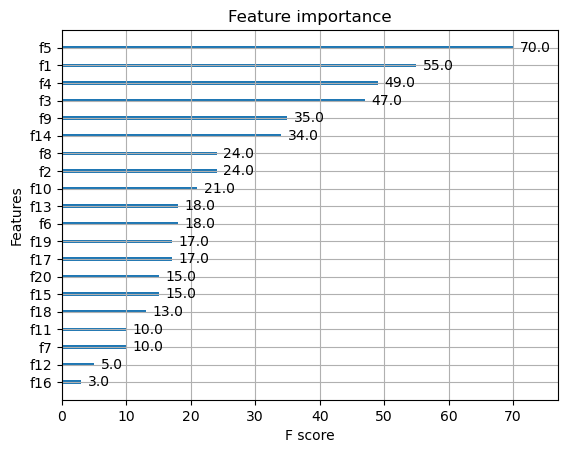

In [10]:
# find most important features
from xgboost import plot_importance
plot_importance(xgb_best_so_far)
plt.show()

In [18]:
train_reduced = train[['f4','f5','f1','f3','target']]
X = train_reduced.drop(['target'], axis=1)
y = train_reduced['target']

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_best_so_far.fit(X_train_reduced, y_train_reduced)
y_pred = xgb_best_so_far.predict(X_test_reduced)
mse = mean_squared_error(y_test_reduced, y_pred)
print('RMSE:', np.sqrt(mse))
print('MSE:', mse)

RMSE: 1.8433906998835963
MSE: 3.398089272417335


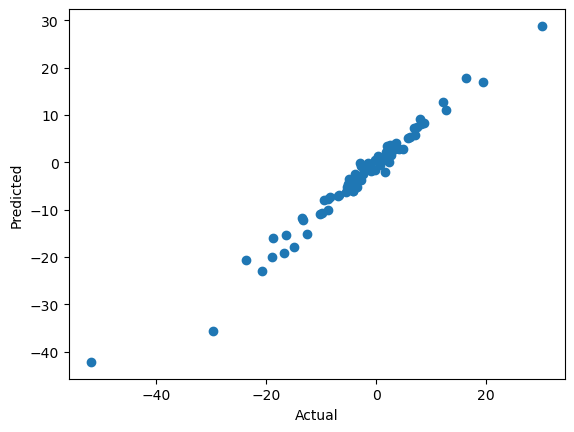

In [12]:
# plot predictions vs actual
plt.scatter(y_test_reduced, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [13]:
# predict test set and save to csv with ID, target
test_reduced = test[['id', 'f4','f5','f1','f3']]
test_reduced = test_reduced.drop(['id'], axis=1)
predictions = xgb_best_so_far.predict(test_reduced)
predictions = pd.DataFrame(predictions, columns=['target'])
predictions = pd.concat([test, predictions], axis=1)
# predictions = predictions[['target']]
predictions = predictions[['id', 'target']]
predictions

,id,target
0,401,-35.790668
1,402,-7.315050
2,403,-0.580257
3,404,-3.503757
4,405,2.754920
...,...,...
795,1196,1.120293
796,1197,1.996570
797,1198,25.000826
798,1199,-2.546295


In [ ]:
# # drop the 2nd column using its id
# predictions = predictions.drop([predictions.index[1]])
# predictions

In [14]:
predictions.to_csv('data/kaggle_submission_bova_5.csv', index=False)

---

## GMM

In [ ]:
# gaussian process regressor
from sklearn.gaussian_process import GaussianProcessRegressor

# [(1.0, SimpleRegressionPipeline({'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'gaussian_process', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'minmax', 'regressor:gaussian_process:alpha': 0.015101741903765523, 'regressor:gaussian_process:thetaL': 1.2894855172471412e-07, 'regressor:gaussian_process:thetaU': 57350.099005831544},
# dataset_properties={
#   'task': 4,
#   'sparse': False,
#   'multioutput': False,
#   'target_type': 'regression',
#   'signed': False}))]

from sklearn.gaussian_process.kernels import RBF, ConstantKernel
kernel = ConstantKernel() * RBF()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)
gpr.fit(X_train, y_train)
y_pred = gpr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('RMSE:', np.sqrt(mse))